# The fraction force applied on an object fallen into the Yvette river

Chensheng LUO (Sofiane)   
Student at CentraleSupélec  
***ATTENTION!***
To be able to perform all of the calculate in this file, the following package are needed, which can be installed by *Anaconda*.
- ```math```
- ```dolfin``` and ```fenics```
- ```matplotlib.pyplot```
- ```numpy```
- ```mshr```   

If you don't have the corresponding module, some error message may occur.   
A precalculated version is availiable in [this Github link]() and you can see the overall result even if you don't have all the module.

## Description of the model

<!-- 10 lines max -->
Imagine an object falls into the Yvette river. We try to calculate the friction force $f$ applied by the water on this object.   

With the knowledge studied of fluid mechanics, the velocity of the fluid ($\vec{u}$) can be described by the famous Navier-Stokes equation [1]:
\begin{equation}\tag{NS}
\rho \frac{D \vec{u}}{D t}=-\nabla p+\mu \nabla^{2} \vec{u}+\frac{1}{3}\mu \nabla (\nabla \cdot \vec{u})+\rho \vec{g}
\end{equation}

The following assumption is made to simplify the equation:
- the fluid is incompressible($\nabla \cdot \vec{u}= 0$) 
- we calculate in the steady state with a low Renold number($Re<<1$) such that $\frac{D \vec{u}}{D t}=0$
- the gravity is negliged($\vec{g}=\vec{0}$) and we study in 2D, with the height of the object $H=1m$


As the river is long, we make two fictitious sections($AD$,$BC$) on the river to study this problem in a 2D rectangle with a circle in center as the object ($\Omega$). 
<img src="https://raw.githubusercontent.com/lcs27/cours-edp/main/project/domaine.jpg" alt="The domained studied" width="500" height="313" align="bottom" />
At the border of the river($AB$, $CD$) and of the object($\partial\Sigma$), the velocity of the fluid is zero ($\vec{u}=\vec{0}$, no-slip condition). The two fictitious sections are supposed to be at infinity and the velocity $\vec{u}=U_{0}\frac{4y(H-y)}{H^{2}}\vec{e_{x}}$, with $U_{0}$ a random variable. The position dropped $Y$ is also a random variable.

## Equation

### PDE

<!-- 20 lines max -->
With the assumption above, we can simplify the equation **(NS)** to the following equations.This kind of flow is called **Stokes flow** [2].

\begin{equation}
\begin{cases}
\nabla p=\mu \nabla^{2} \vec{u}\\
\nabla \cdot \vec{u}=0
\end{cases}
\end{equation}
where $p$ is the pressure, $\mu$ is the viscosity for the fluid and $\vec{u}$ is the velocity.

By taking the reference length $L_{ref}=1m$, the reference velocity $V_{ref}=1m/s$, the reference pressure $P_{ref}=1Pa$, we can get the dimensionless equation
\begin{equation}
\begin{cases}
\nabla \widetilde{p}=\widetilde{\mu} \nabla^{2} \vec{\widetilde{u}}\\
\nabla \cdot \vec{\widetilde{u}}=0
\end{cases}
\end{equation}
with $\widetilde{\mu}=\frac{\mu V_{ref}}{L_{ref} P_{ref}}$ , $\widetilde{p}=\frac{p}{P_{ref}}$, $\widetilde{u}=\frac{u}{V_{ref}}$ and $\widetilde{x}=\frac{x}{L_{ref}}$ etc.
By considering the boudary conditions, we have
\begin{equation}
\tag{S}
\begin{cases}
\begin{cases}
\nabla \widetilde{p}=\widetilde{\mu} \nabla^{2} \vec{\widetilde{u}} \qquad (S_{1})\\
\nabla \cdot \vec{\widetilde{u}}=0 \qquad (S_{2})
\end{cases}\\
(CL)
\begin{cases}
\vec{\widetilde{u}}=\widetilde{U}_{0}\vec{e_{x}} \quad \mbox{on}\ AD, BC \\
\vec{\widetilde{u}}=0 \quad \mbox{on}\ AB, CD,\partial \Sigma
\end{cases}
\end{cases}
\end{equation}
For the equation above, we take the viscosity of water at $298K$, we have $\widetilde{\mu}=8.9\times 10^{-4}$[3]. For the velocity at infinit, we take $\widetilde{U}_{0}=\frac{U_{0}}{V_{ref}} \sim N(5, 0.1)$

### Variational formula

From this part, we omit the notation $\widetilde{\cdot}$ and take $u$ to be $\widetilde{u}$.  
Let's considering the test function $(\vec{v},q) \in H^{1}_{0}(\Omega) \times L^{2}_{0}(\Omega)$ [4] By intergration by part and by adding this to equation, we have: 
\begin{equation}
\int_{\Omega} (-\mu  \nabla \vec{u} : \nabla \vec{v} + p  \nabla\cdot\vec{v}+ q \nabla \cdot \vec{u})dx= 0
\end{equation} 
Thus, we have the bilinear form: $a((\vec{u},p),(\vec{v},q))= \int_{\Omega} -\mu  \nabla \vec{u} : \nabla \vec{v} + p  \nabla\cdot\vec{v}+ q \nabla \cdot \vec{u}$ and the linear forms: $f((\vec{v},q))=0$
We can prove that $a$ is continous and coercive and obviously $f$ is continuous.

### preconditioner 

According to [5], a preconditionner should be made as
\begin{equation}
b((\vec{u},p),(\vec{v},q))= \int_{\Omega} (-\mu  \nabla \vec{u} : \nabla \vec{v} + p  q)dx
\end{equation}

## Simulation-Conclusion

### Basic functions and defaut solution

We first define the necessary functions:  ```solve_stokes``` is the FEniCS solver to solve function, ```plot_field``` is the function to draw a field and ```calculate_force``` is a function to calculate the force applied on the object with $\vec{F}=H\int_{\partial \Sigma} p \vec{n}\cdot\vec{e_{x}}ds$.

In [1]:
import math
from dolfin import *
from fenics import *
import matplotlib.pyplot as plt
import numpy as np
from mshr import *
# To enter an interactive mode, please uncomment the following line
#%matplotlib notebook

In [7]:
def solve_stokes(X=10,Y=3,U0=5,phi=1):
    '''
    The FEniCS solver used to solve this question for 
    
    Input
    ----------------------
    - (X,Y) the position of the object dropped, predefined to be the center, default to be (10,3)
    - U0 velocity of the river, defaut to be 5
    - phi the diameter of the object, defaut to be 1
    
    Output
    ----------------------
    - u, the velocity field(vector field)
    - p, the pressure field(scalar field)
    - V, the space of u
    - Q, the space of p
    - W, the space V*Q
    - mesh, the mesh of the field
    - boundary_subdomains, the boundary subdomains
    '''
    # Scaled variables
    D = 20; H = 6; mu =8.9*1e-4;
    nx = 100 ; order = 1;

    # Create mesh and define function space
    base = Rectangle(Point(0, 0), Point(D, H))
    hole = Circle(Point(X, Y), phi/2)
    mesh = generate_mesh(base - hole, nx)

    # Define the mixed function space
    Element1 = VectorElement('P', mesh.ufl_cell(), order)
    Element2 = FiniteElement( 'P', mesh.ufl_cell(), order)
    W_elem = MixedElement([Element1, Element2])
    V = FunctionSpace(mesh,Element1)
    Q = FunctionSpace(mesh,Element2)
    W = FunctionSpace(mesh, W_elem)

    # Define boundary condition
    tol = 1E-10

    inflow =Expression(('A*4*x[1]*(B-x[1])/B/B','0'),A=U0,B=H,degree=2)
    def left_right_boundary(x, on_boundary):
        return on_boundary and (abs(x[0])<tol or abs(x[0] - D)<tol)
    bc_LR = DirichletBC(W.sub(0), inflow ,left_right_boundary)

    def top_bottom_boundary(x, on_boundary):
        return on_boundary and (abs(x[1])<tol or abs(x[1] - H)<tol)
    bc_TB = DirichletBC(W.sub(0), Constant((0,0)),top_bottom_boundary)

    def circle_boundary(x, on_boundary):
        r = math.sqrt((x[0]-X)*(x[0]-X)+(x[1]-Y)*(x[1]-Y))
        return on_boundary and abs(r-phi/2)<0.01
    bc_CR = DirichletBC(W.sub(0), Constant((0,0)),circle_boundary)

    bc = [bc_LR,bc_TB,bc_CR]
    
    # Define boundary subdomaines
    boundary_subdomains = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
    boundary_subdomains.set_all(0)
    AutoSubDomain(left_right_boundary).mark(boundary_subdomains, 1)
    AutoSubDomain(top_bottom_boundary).mark(boundary_subdomains, 2)
    AutoSubDomain(circle_boundary).mark(boundary_subdomains, 3)

    # Define variational formula
    (u, p) = TrialFunctions(W)
    (v, q) = TestFunctions(W)
    a = -mu*inner(grad(u), grad(v))*dx + div(v)*p*dx + q*div(u)*dx
    f = inner(Constant((0, 0)), v)*dx

    # Construction of preconditioner matrix
    b = -mu*inner(grad(u), grad(v))*dx + p*q*dx
    A, bb = assemble_system(a, f, bc)
    P, btmp = assemble_system(b, f, bc)
    solver = KrylovSolver("tfqmr", "amg")
    solver.set_operators(A, P)

    # Solve
    U = Function(W)
    solver.solve(U.vector(), bb)
    u, p = U.split()
    u = project(u,V)
    p = project(p,Q)
    return u,p,V,Q,W,mesh,boundary_subdomains

def plot_field(u,mesh,tit='',labelx='',labely=''):
    '''
    To plot a field(scalar or vector)
    
    Input
    ----------------------
    - u, the field
    - mesh, the mesh of the domaine
    - tit, the title, default to be vide string
    - labelx, the xlabel, default to be vide string
    - labely, the ylabel, default to be vide string
    '''
    plt.figure()
    plot(mesh,alpha=0.05)
    plu=plot(u)
    plt.colorbar(plu,fraction=0.2, pad=0.04)
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.title(tit)

def calculate_force(p,mesh,boundary_subdomains,H=1):
    '''
    To calculate the force applied on the object
    
    Input
    ------------------
    - p, the pressure field
    - mesh, the mesh of the domaine
    - boundary_subdomains
    - H, the height of the object, defaut to be 1
    
    Output
    ------------------
    - force, the force on the object
    '''
    dss = ds(subdomain_data=boundary_subdomains)
    n = FacetNormal(mesh)
    ex  = Constant((1,0))
    f = p*dot(n, ex)* dss(3)
    force = H*assemble(f)
    return force

Let's first calculate the result for a defaut parameter ($X=10,Y=3,U_{0}= 5,\phi=1$).

The force applied on the object is  0.038601805232944764 .
The maximum of velocity is  5.760463661159857 .


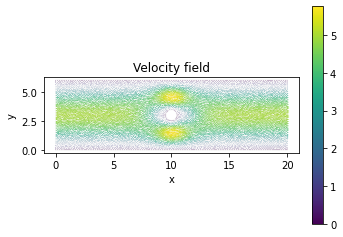

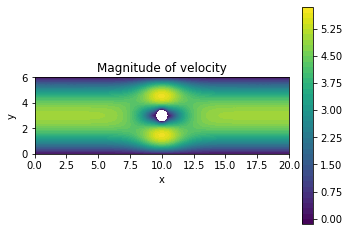

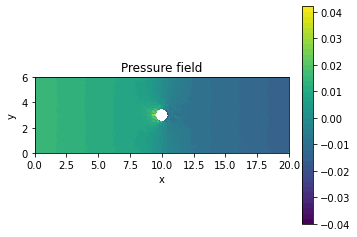

In [8]:
u,p,V,Q,W,mesh,boundary_subdomains = solve_stokes()

u_mag=sqrt(dot(u,u))
u_mag=project(u_mag,FunctionSpace(mesh,'P',1))
u_array=np.array(u_mag.vector())

plot_field(u,mesh,tit='Velocity field',labelx='x',labely='y')
plot_field(u_mag,mesh,tit='Magnitude of velocity',labelx='x',labely='y')
plot_field(p,mesh,tit='Pressure field',labelx='x',labely='y')
print('The force applied on the object is ',calculate_force(p,mesh,boundary_subdomains),'.')
print('The maximum of velocity is ',np.max(u_array),'.')

**Conclusion:** We can then conclude that the fraction force applied on the object is $F=0.03N$ and their is a small augmentation of velocity around the object.

### The influence of position

The variation of $X$ is of no sense so we make $Y$ to be a random variable, with 

## Bibliography

[1] https://en.wikipedia.org/wiki/Navier%E2%80%93Stokes_equations     
[2] https://en.wikipedia.org/wiki/Stokes%27_law  
[3] https://www.engineersedge.com/physics/water__density_viscosity_specific_weight_13146.htm 
[4] Mu L, Ye X. A simple finite element method for the Stokes equations[J]. Advances in Computational Mathematics, 2017, 43(6): 1305-1324.  
[5] https://fenicsproject.org/olddocs/dolfin/1.3.0/python/demo/documented/stokes-iterative/python/documentation.html